In [2]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Update this path if you move the notebook
BASE_PATH = r"C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset"

TRAIN_LABELS_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "yolo_labels")
VAL_LABELS_DIR = os.path.join(BASE_PATH, "UVH-26-Val", "yolo_labels")

# Class names (Must match the order in your YAML file)
CLASSES = [
    'Hatchback', 'Sedan', 'SUV', 'MUV', 'Bus', 'Truck', 
    'Three-wheeler', 'Two-wheeler', 'LCV', 'Mini-bus', 
    'Tempo-traveller', 'Bicycle', 'Van'
]

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("Configuration loaded.")

Configuration loaded.


In [3]:
def load_yolo_data(root_dir, subset_name):
    """
    Recursively scans all .txt files in the directory and parses YOLO lines.
    Returns a Pandas DataFrame.
    """
    print(f"Scanning {subset_name} labels in {root_dir}...")
    data = []
    
    # Recursively find all txt files (handles subfolders like 001, 002...)
    txt_files = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)
    
    for file_path in txt_files:
        # Skip empty files
        if os.path.getsize(file_path) == 0:
            continue
            
        with open(file_path, "r") as f:
            lines = f.readlines()
            
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                try:
                    cls_id = int(parts[0])
                    x, y, w, h = map(float, parts[1:])
                    
                    # Safety check for class ID
                    if 0 <= cls_id < len(CLASSES):
                        class_name = CLASSES[cls_id]
                        data.append({
                            "subset": subset_name,
                            "class_id": cls_id,
                            "class_name": class_name,
                            "x_center": x,
                            "y_center": y,
                            "width": w,
                            "height": h,
                            "area": w * h,
                            "aspect_ratio": w / h if h > 0 else 0
                        })
                except ValueError:
                    continue # Skip malformed lines
    
    print(f"Loaded {len(data)} annotations for {subset_name}.")
    return pd.DataFrame(data)

In [4]:
# Load Training and Validation Data
df_train = load_yolo_data(TRAIN_LABELS_DIR, "Train")
df_val = load_yolo_data(VAL_LABELS_DIR, "Validation")

# Combine into one DataFrame for analysis
df = pd.concat([df_train, df_val], ignore_index=True)

# Preview the data
if df.empty:
    print("WARNING: No data found! Check your paths.")
else:
    print(f"\nTotal Annotations: {len(df)}")
    display(df.head())

Scanning Train labels in C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset\UVH-26-Train\yolo_labels...
Loaded 252441 annotations for Train.
Scanning Validation labels in C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset\UVH-26-Val\yolo_labels...
Loaded 63427 annotations for Validation.

Total Annotations: 315868


,subset,class_id,class_name,x_center,y_center,width,height,area,aspect_ratio
0,Train,7,Two-wheeler,0.133052,0.578472,0.092708,0.190741,0.017683,0.486041
1,Train,6,Three-wheeler,0.205740,0.354046,0.057031,0.088889,0.005069,0.641598
2,Train,8,LCV,0.718453,0.396500,0.044271,0.109259,0.004837,0.405193
3,Train,7,Two-wheeler,0.602823,0.423861,0.025000,0.091667,0.002292,0.272726
4,Train,7,Two-wheeler,0.749646,0.551444,0.070312,0.099074,0.006966,0.709692


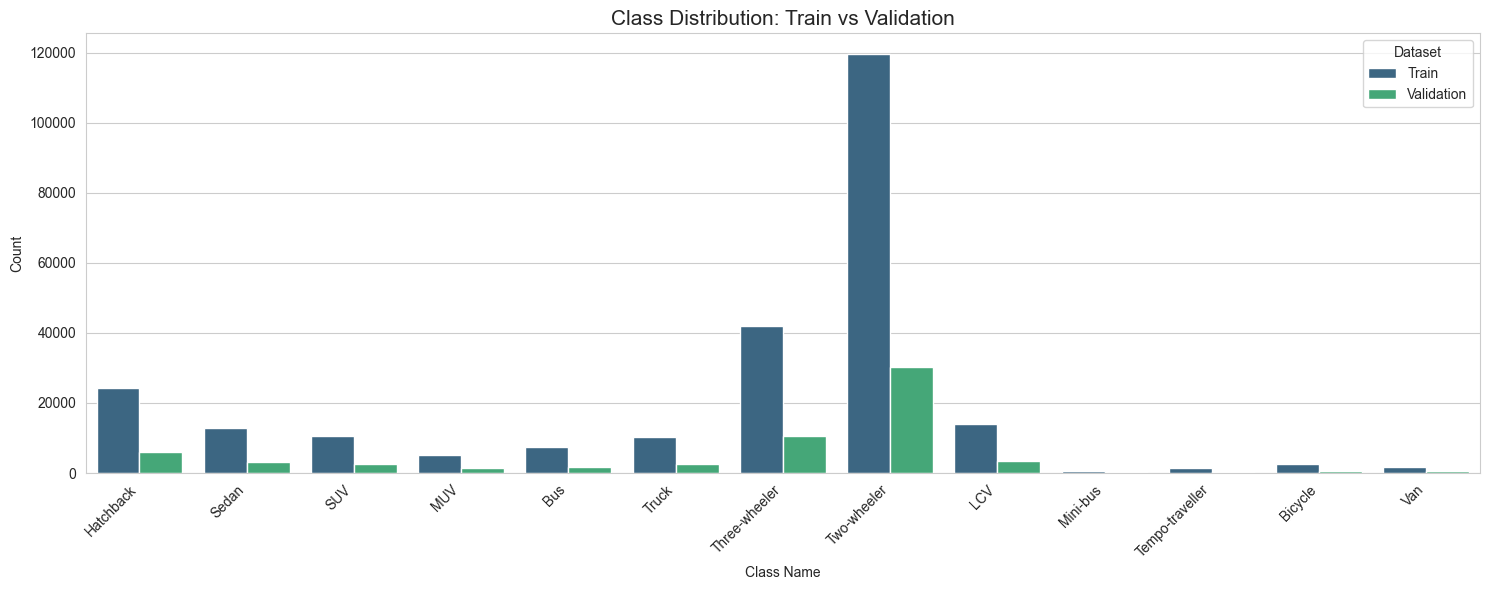

In [5]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='class_name', hue='subset', order=CLASSES, palette='viridis')

plt.title("Class Distribution: Train vs Validation", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

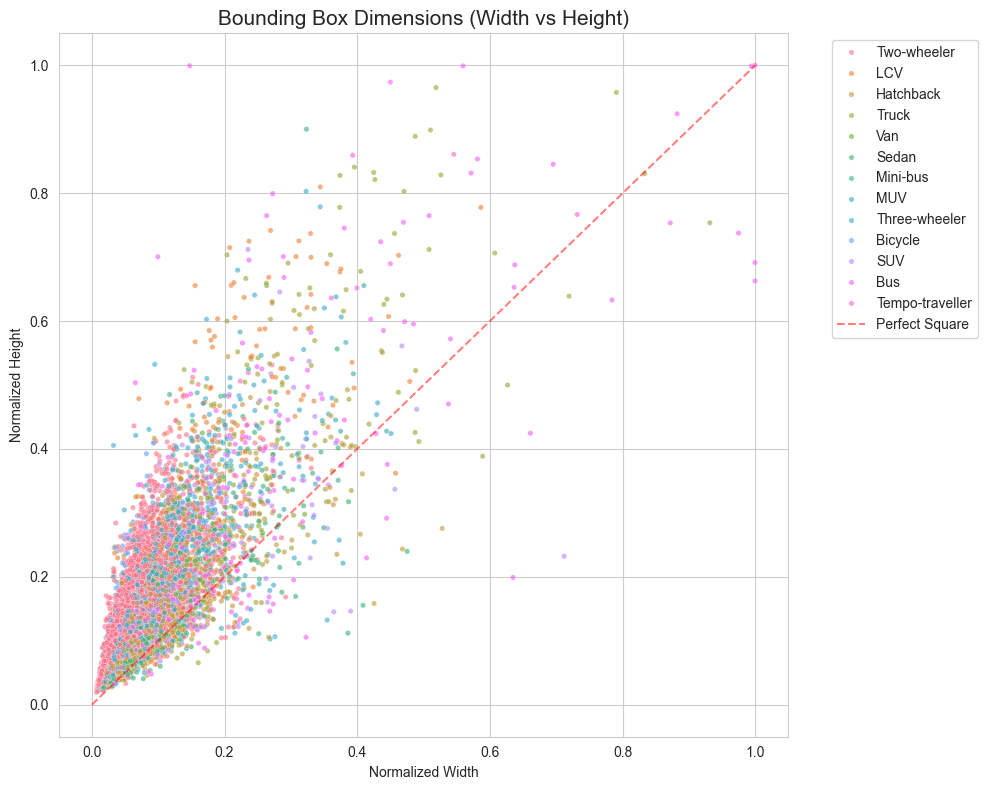

In [6]:
plt.figure(figsize=(10, 8))

# Sample data if it's too large to prevent lag (e.g., max 10k points)
plot_df = df.sample(min(len(df), 10000))

sns.scatterplot(
    data=plot_df, 
    x='width', 
    y='height', 
    hue='class_name', 
    alpha=0.6,
    s=15  # Dot size
)

# Draw a diagonal line (Square boxes)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label="Perfect Square")

plt.title("Bounding Box Dimensions (Width vs Height)", fontsize=15)
plt.xlabel("Normalized Width")
plt.ylabel("Normalized Height")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

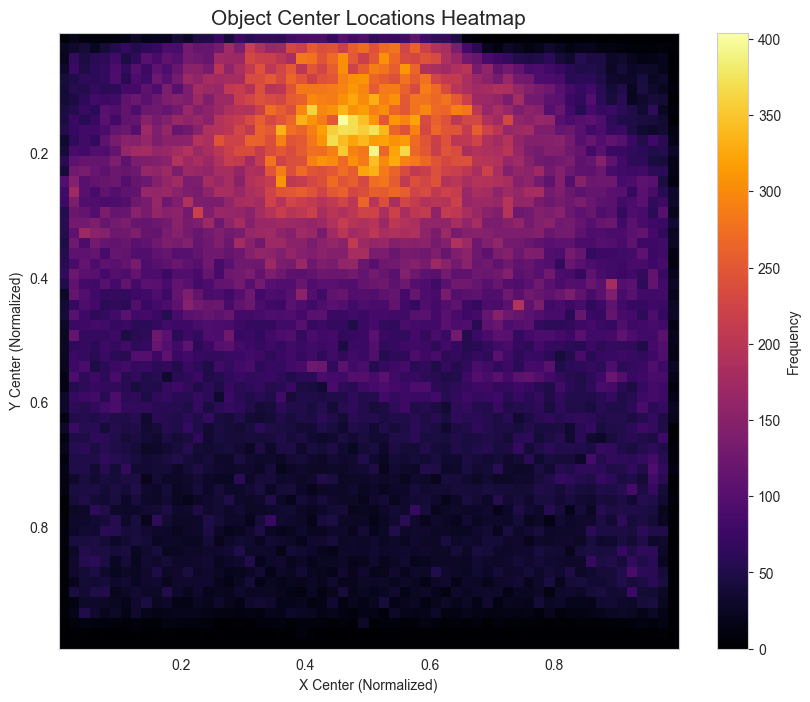

In [7]:
plt.figure(figsize=(10, 8))

plt.hist2d(df['x_center'], df['y_center'], bins=60, cmap='inferno')

plt.colorbar(label='Frequency')
plt.title("Object Center Locations Heatmap", fontsize=15)
plt.xlabel("X Center (Normalized)")
plt.ylabel("Y Center (Normalized)")

# Invert Y axis because images start from top-left (0,0)
plt.gca().invert_yaxis()
plt.show()

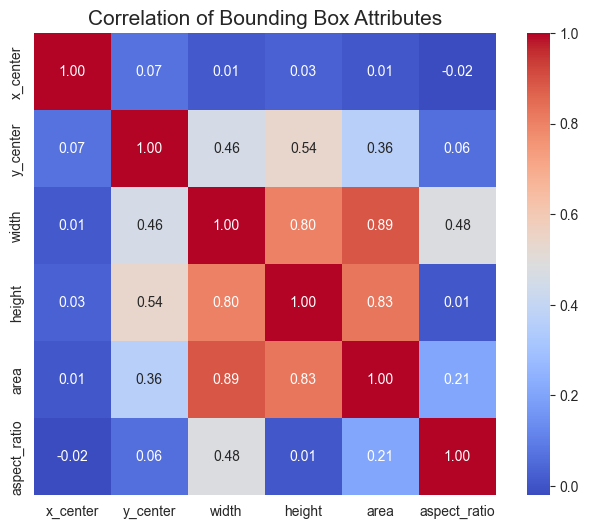

In [8]:
plt.figure(figsize=(8, 6))

corr_cols = ['x_center', 'y_center', 'width', 'height', 'area', 'aspect_ratio']
corr_matrix = df[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title("Correlation of Bounding Box Attributes", fontsize=15)
plt.show()

In [9]:
print("--- Summary Statistics by Subset ---")
# Group by subset to see if Train/Val have similar stats
summary = df.groupby('subset')[['width', 'height', 'area']].describe()
display(summary)

print("\n--- Class Counts ---")
class_counts = df.groupby(['subset', 'class_name']).size().unstack(fill_value=0)
display(class_counts)

--- Summary Statistics by Subset ---


width                                                    \
               count      mean       std       min       25%       50%   
subset                                                                   
Train       252441.0  0.083209  0.078896  0.001703  0.035417  0.058854   
Validation   63427.0  0.083271  0.078413  0.000553  0.035417  0.059375   

                                  height            ...                      \
                 75%       max     count      mean  ...       75%       max   
subset                                              ...                       
Train       0.102083  0.999875  252441.0  0.154142  ...  0.194444  0.999917   
Validation  0.102083  0.999974   63427.0  0.154589  ...  0.195370  0.999991   

                area                                                   \
               count      mean      std       min       25%       50%   
subset                                                                  
Train       252441.0  0.020129  0.04365  0.000048  0.002836  0.007051   
Validation   63427.0  0.020044  0.04262  0.000005  0.002857  0.007159   

                                
                 75%       max  
subset                          
Train       0.019059  0.997672  
Validation  0.019228  0.999689  

[2 rows x 24 columns]


--- Class Counts ---


class_name,Bicycle,Bus,Hatchback,LCV,MUV,Mini-bus,SUV,Sedan,Tempo-traveller,Three-wheeler,Truck,Two-wheeler,Van
subset,,,,,,,,,,,,,
Train,2710,7456,24196,13854,5208,699,10536,12799,1345,41961,10415,119519,1743
Validation,681,1830,6094,3491,1315,174,2639,3151,335,10467,2596,30211,443


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_39184\2022188270.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='class_name', y='area', palette='viridis', order=CLASSES)


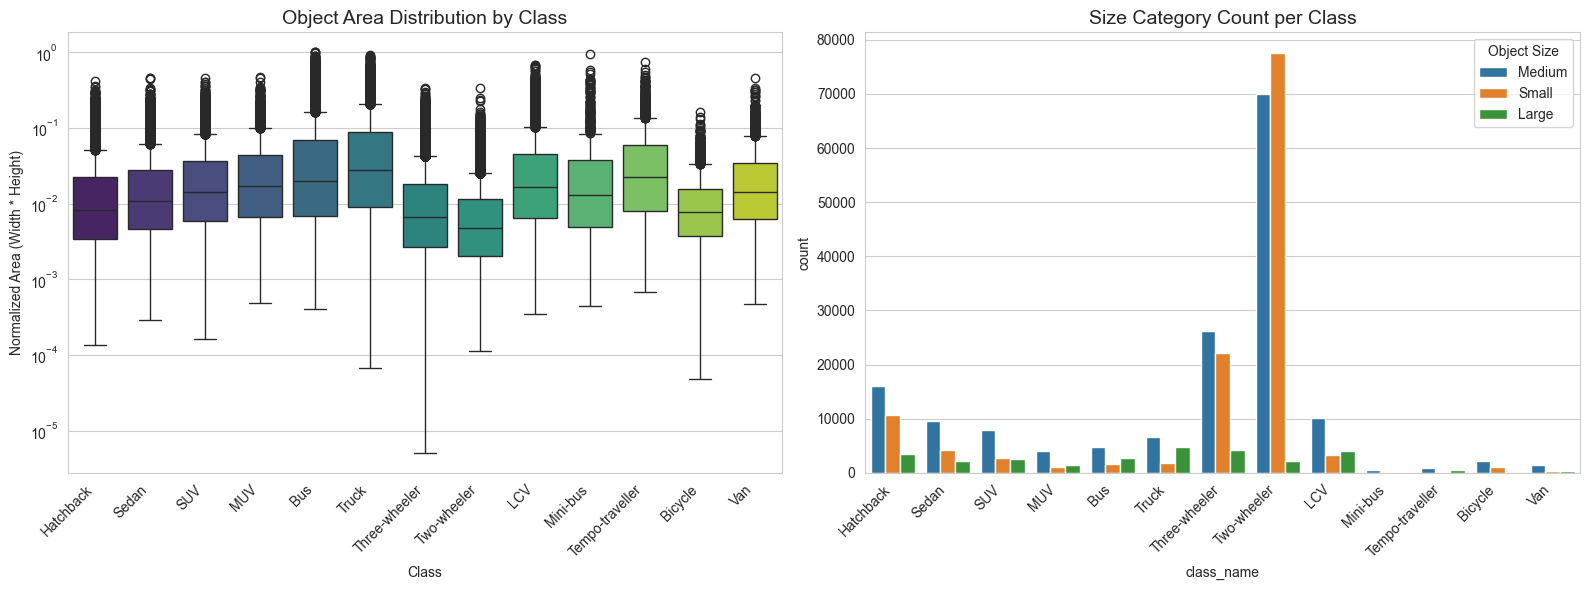

In [10]:
# --- ADD THIS TO A NEW CELL IN YOUR NOTEBOOK ---

# 1. Objects per Image (Density)
# This tells us if images are simple (1-2 cars) or crowded (20+ cars)
img_counts = df.groupby(['subset', 'filename_base']).size() if 'filename_base' in df.columns else df.groupby(['subset']).size() # Approximation if filename missing
# Let's assume we can group by image. Since we loaded a DataFrame, let's create a proxy for 'image' 
# if 'filename' isn't explicitly there, we can't do per-image count easily without reloading.
# Let's stick to Area distribution which is safer with current DF.

plt.figure(figsize=(16, 6))

# Plot A: Box Area by Class (Are rare classes smaller?)
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='class_name', y='area', palette='viridis', order=CLASSES)
plt.title("Object Area Distribution by Class", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Normalized Area (Width * Height)")
plt.yscale('log') # Log scale because areas vary wildly

# Plot B: Small vs Large Object Count
# Define thresholds: Small (<0.5% area), Medium (0.5-5%), Large (>5%)
def get_size_category(area):
    if area < 0.005: return 'Small'
    elif area < 0.05: return 'Medium'
    else: return 'Large'

df['size_category'] = df['area'].apply(get_size_category)

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='class_name', hue='size_category', order=CLASSES)
plt.title("Size Category Count per Class", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Object Size")

plt.tight_layout()
plt.show()


--- GROUP 1: Bus vs. Mini-bus ---
Finding examples for: Bus (ID: 4)...


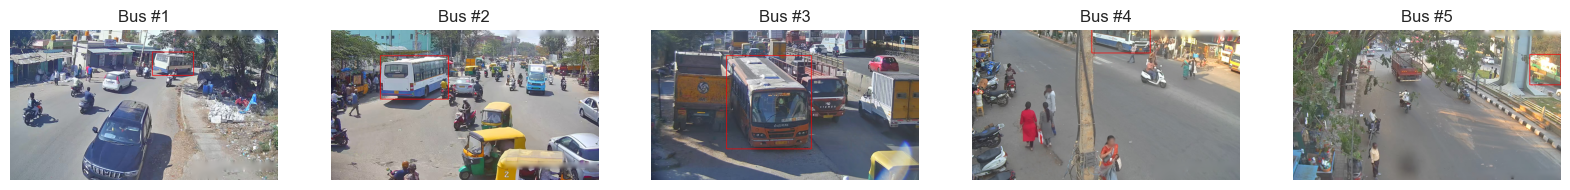

Finding examples for: Mini-bus (ID: 9)...


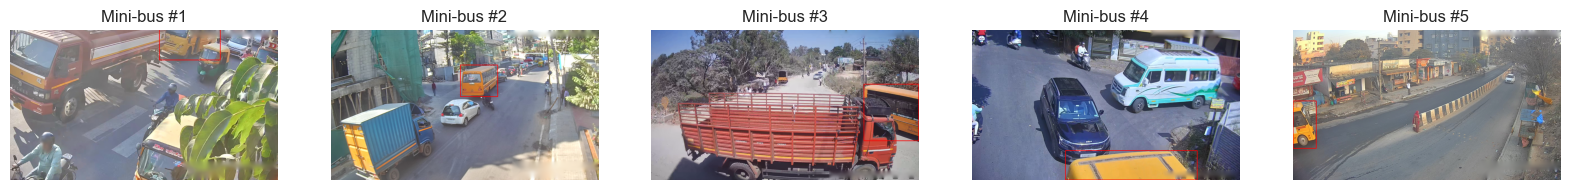


--- GROUP 2: Truck vs. LCV ---
Finding examples for: Truck (ID: 5)...


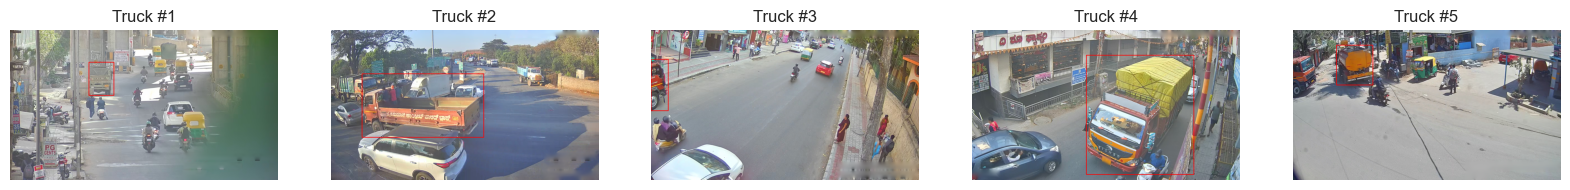

Finding examples for: LCV (ID: 8)...


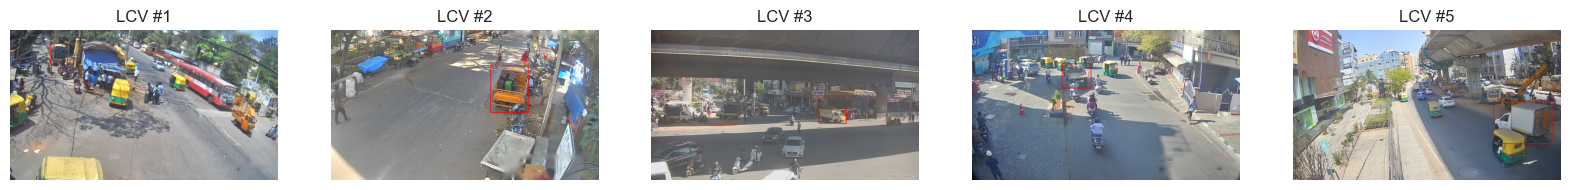

In [12]:
import cv2
import random
import glob
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Ensure these are correct. Using 'r' prefix for Windows paths is good practice.
BASE_PATH = r"C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset"
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "data")
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "yolo_labels")

def get_image_samples(target_class_id, num_samples=5):
    """
    Scans label files to find specific examples of a class.
    Returns a list of (image_path, bbox) tuples.
    """
    samples = []
    
    # Recursively find label files
    all_labels = glob.glob(os.path.join(TRAIN_LBL_DIR, "**", "*.txt"), recursive=True)
    random.shuffle(all_labels) # Shuffle to get random examples
    
    for lbl_path in all_labels:
        if len(samples) >= num_samples:
            break
            
        if os.path.getsize(lbl_path) == 0: continue
        
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            
            if cls_id == target_class_id:
                # Found one!
                # 1. Reconstruct Image Path
                # Label: .../yolo_labels/001/image.txt -> Image: .../data/001/image.jpg
                
                # Get subfolder (e.g., "001")
                rel_dir = os.path.relpath(os.path.dirname(lbl_path), TRAIN_LBL_DIR)
                base_name = os.path.splitext(os.path.basename(lbl_path))[0]
                
                # Try finding the image extensions
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    try_path = os.path.join(TRAIN_IMG_DIR, rel_dir, base_name + ext)
                    if os.path.exists(try_path):
                        img_path = try_path
                        break
                
                if img_path:
                    # Parse box for drawing
                    x_c, y_c, w, h = map(float, parts[1:])
                    samples.append((img_path, (x_c, y_c, w, h)))
                    break # Move to next file (don't pick same image twice)
    
    return samples

def plot_samples(class_name, class_id):
    print(f"Finding examples for: {class_name} (ID: {class_id})...")
    samples = get_image_samples(class_id, num_samples=5)
    
    if not samples:
        print(f"Warning: No samples found for {class_name}.")
        return

    plt.figure(figsize=(20, 5))
    for i, (img_path, bbox) in enumerate(samples):
        # Load Image
        img = cv2.imread(img_path)
        if img is None: continue # Skip if image load fails
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape
        
        # Un-normalize coordinates
        x_c, y_c, w, h = bbox
        x1 = int((x_c - w/2) * w_img)
        y1 = int((y_c - h/2) * h_img)
        x2 = int((x_c + w/2) * w_img)
        y2 = int((y_c + h/2) * h_img)
        
        # Draw Box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3) # Red Box
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} #{i+1}")
    plt.show()

# --- EXECUTE VISUAL COMPARISON ---

print("\n--- GROUP 1: Bus vs. Mini-bus ---")
# Bus (ID 4) vs Mini-bus (ID 9)
plot_samples("Bus", 4)
plot_samples("Mini-bus", 9)

print("\n--- GROUP 2: Truck vs. LCV ---")
# Truck (ID 5) vs LCV (ID 8)
# LCV = Light Commercial Vehicle (often looks like a small truck/pickup)
plot_samples("Truck", 5)
plot_samples("LCV", 8)